### First step: calculate home location

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from itertools import islice
from math import radians, cos, sin, asin, sqrt
%matplotlib inline

In [ ]:
# # Initialize a dictionary to save each user's call records (User ID -> {CELLID -> Number of Calls})
# user_calls = {}

# # Read the data file line by line
# with open('CDR/cdr_Caucaia-002.txt', 'r') as file:
#     for line in file:
#         # Split each line into parts
#         parts = line.strip().split(';')
        
#         # Extract the columns of interest: Caller ID, CELLID
#         caller_id = parts[4]
#         cell_id = parts[7]
        
#         # Update the call records for the user
#         if caller_id not in user_calls:
#             user_calls[caller_id] = {}
#         if cell_id not in user_calls[caller_id]:
#             user_calls[caller_id][cell_id] = 1
#         else:
#             user_calls[caller_id][cell_id] += 1

In [ ]:
# # Print the first 5 entries of the user_calls
# for user_id, call_records in islice(user_calls.items(), 5):
#     print(f'User ID: {user_id}, Call Records: {call_records}')

In [ ]:
# # Calculate the home location for each user based on the number of calls
# home_locations = {}
# for user, calls in user_calls.items():
#     # Find the CELLID with the highest number of calls
#     home_location = max(calls, key=calls.get)
#     home_locations[user] = home_location

# # Output the results
# for user, home_location in home_locations.items():
#     print(f'User {user} has home location at CELLID {home_location}')

In [ ]:
# # Print the first 5 entries of the home_locations
# for user, home_location in islice(home_locations.items(), 5):
#     print(f'User {user} has home location at CELLID {home_location}')

In [ ]:
# # Save the user_call to a CSV file
# with open('user_call_records.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['User ID', 'Cell ID', 'Call Count'])
    
#     for user_id, call_records in user_calls.items():
#         for cell_id, call_count in call_records.items():
#             writer.writerow([user_id, cell_id, call_count])

In [ ]:
# # Save the home_locations to a CSV file
# with open('home_locations.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['User', 'Home Location CELLID'])  # Write the header row
#     for user, home_location in home_locations.items():
#         writer.writerow([user, home_location])  # Write each user's home location

In [3]:
# Load user_call_records csv file
user_calls = {}

with open('user_call_records.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        user_id, cell_id, call_count = row
        if user_id not in user_calls:
            user_calls[user_id] = {}
        user_calls[user_id][cell_id] = int(call_count)

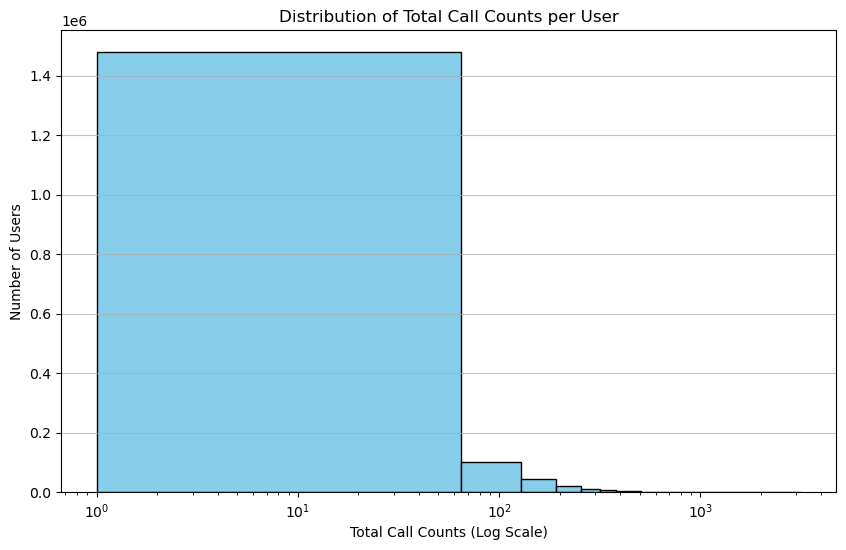

In [23]:
# Plot the distribution
total_calls_users = [sum(calls.values()) for calls in user_calls.values()]

plt.figure(figsize=(10, 6))
plt.hist(total_calls_users, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Call Counts per User')
plt.xlabel('Total Call Counts (Log Scale)')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.xscale('log')

plt.show()

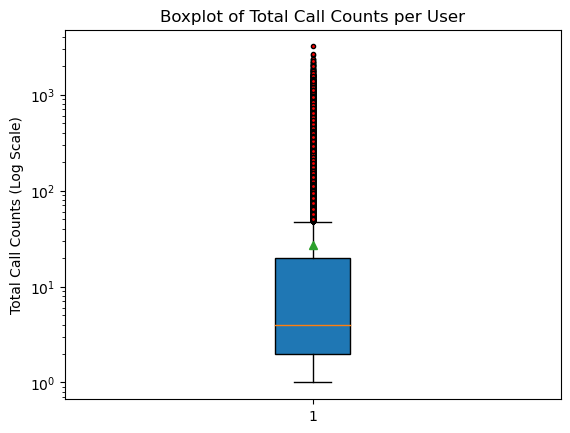

In [24]:
plt.boxplot(total_calls_users, vert=True, patch_artist=True, 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=3),
            showmeans=True)

plt.title('Boxplot of Total Call Counts per User')
plt.ylabel('Total Call Counts (Log Scale)')
plt.yscale('log')

In [19]:
pd.DataFrame(total_calls_users).describe()

,0
count,1.673445e+06
mean,2.736425e+01
std,6.640063e+01
min,1.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,2.000000e+01
max,3.174000e+03


In [5]:
# Print the first 5 entries of the user_calls
for user_id, call_records in islice(user_calls.items(), 5):
    print(f'User ID: {user_id}, Call Records: {call_records}')

User ID: 99BDAF58BE2F410B210918401FBB8E2C, Call Records: {'3244': 87, '3236': 127, '3242': 18, '3201': 3, '3234': 7, '3243': 1, '1572': 1}
User ID: CD933F79E567B215ACE12699BAFE7378, Call Records: {'3262': 5}
User ID: 00B1DD1A94FB197B8495CE0F1B0C9403, Call Records: {'3172': 17, '3173': 1}
User ID: 707840C02E68FFB11B9969354F25D389, Call Records: {'3822': 160, '3852': 50, '3244': 1, '3221': 1, '3823': 3, '3851': 1}
User ID: AB60C0781BEC5EB9BEAC0E492A1D7FC3, Call Records: {'3853': 179, '3823': 40, '892': 24, '3851': 26, '3191': 8, '3822': 1, '3192': 6, '3852': 1, '3193': 14, '3222': 2, '3225': 1, '3182': 1, '3213': 2, '3202': 1, '3203': 2, '891': 3, '3821': 3, '3244': 1, '3831': 2}


In [3]:
# Load home_locations csv file
home_locations = {}

with open('home_locations.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        user, home_location_cellid = row
        home_locations[user] = home_location_cellid

In [9]:
# Print the first 5 entries of the home_locations
for user, home_location in islice(home_locations.items(), 5):
    print(f'User {user} has home location at CELLID {home_location}')

User 99BDAF58BE2F410B210918401FBB8E2C has home location at CELLID 3236
User CD933F79E567B215ACE12699BAFE7378 has home location at CELLID 3262
User 00B1DD1A94FB197B8495CE0F1B0C9403 has home location at CELLID 3172
User 707840C02E68FFB11B9969354F25D389 has home location at CELLID 3822
User AB60C0781BEC5EB9BEAC0E492A1D7FC3 has home location at CELLID 3853


In [7]:
# Load antenna locations
antenna_locations = {}

with open('Antena/antennas_Caucaia.txt', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)  # Skip the header
    for row in reader:
        cell_id, lat, long = row[0], float(row[3]), float(row[4])
        antenna_locations[cell_id] = (lat, long)

In [21]:
print(len(antenna_locations))

116


In [8]:
# Print the first 5 entries of the antenna_locations
for cell_id, antenna_location in islice(antenna_locations.items(), 5):
    print(f'Cell ID: {cell_id}, Antenna Location: {antenna_location}')

Cell ID: 7537, Antenna Location: (-3.7366699999999997, -38.74306)
Cell ID: 7498, Antenna Location: (-3.73389, -38.65722)
Cell ID: 7478, Antenna Location: (-3.7663900000000003, -38.63389)
Cell ID: 7529, Antenna Location: (-3.6808300000000003, -38.66083)
Cell ID: 7517, Antenna Location: (-3.69444, -38.6225)


In [2]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

In [50]:
# # Calculate social range for each user
# social_ranges = {}


# users_same_cell_calls = {}

# for user, calls in user_calls.items():
#     # Total number of calls made by the user
#     total_calls = sum(calls.values())
#     if total_calls == 0:
#         print(f"User {user} made 0 call.")
#         continue

#     social_range_sum = 0
#     home_location_user = home_locations.get(user)
#     # Assume initially that all calls are within the same cell
#     all_calls_same_cell = True

#     for called_cellid, call_count in calls.items():
#         # Check if call is made to or from a different cell
#         if home_location_user != called_cellid:
#             all_calls_same_cell = False
        
#         # Only calculate distance if both locations are known
#         if home_location_user in antenna_locations and called_cellid in antenna_locations:
#             distance = haversine(*antenna_locations[home_location_user], *antenna_locations[called_cellid])
#             social_range_sum += distance * call_count
#         else:
#             print(f"Missing antenna location for user {user} or cell {called_cellid}.")

#     if all_calls_same_cell:
#         users_same_cell_calls[user] = {'Home CELLID': home_location_user, 'Total Calls': total_calls}

#     social_ranges[user] = social_range_sum / total_calls if total_calls > 0 else 0

In [44]:
# # Print the social range for the first 5 users
# for user, social_range in list(social_ranges.items())[:5]:
#     print(f'User {user} has a social range of {social_range:.2f} km')

User 99BDAF58BE2F410B210918401FBB8E2C has a social range of 7.07 km
User CD933F79E567B215ACE12699BAFE7378 has a social range of 0.00 km
User 00B1DD1A94FB197B8495CE0F1B0C9403 has a social range of 0.00 km
User 707840C02E68FFB11B9969354F25D389 has a social range of 0.41 km
User AB60C0781BEC5EB9BEAC0E492A1D7FC3 has a social range of 0.95 km


In [42]:
# # Save the social range of each user to a CSV file
# with open('social_ranges.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['User ID', 'Social Range (km)'])
#     for user, social_range in social_ranges.items():
#         writer.writerow([user, round(social_range, 2)])

In [51]:
# filename = 'users_same_cell_calls_with_cellid.csv'

# with open(filename, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['User ID', 'Home CELLID', 'Total Calls in Home CELLID'])
    
#     for user, info in users_same_cell_calls.items():
#         writer.writerow([user, info['Home CELLID'], info['Total Calls']])

# print(f"Information about users who only made calls within their home cell has been saved to '{filename}'.")

Information about users who only made calls within their home cell has been saved to 'users_same_cell_calls_with_cellid.csv'.


In [12]:
# Check if all the users called have home locations
missing_called_ids = {}

with open('CDR/cdr_Caucaia-002.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(';')

        # caller_id = parts[4]
        called_id = parts[6]

        if called_id not in home_locations:
            if called_id not in missing_called_ids:
                missing_called_ids[called_id] = 1
            else:
                missing_called_ids[called_id] += 1

In [15]:
# Print the first 5 entries of the missing_called_ids
for missing_called_id, missing_count in islice(missing_called_ids.items(), 5):
    print(f'Missing Called ID: {missing_called_id}, Missing Count: {missing_count}')

Missing Called ID: 9CFBCD1D580246CF2C983D195B54F649, Missing Count: 140
Missing Called ID: DA64FE0973FB116B6D18016DE360889D, Missing Count: 2
Missing Called ID: 0BC3EAE9D47DE038442A082365F6FD5F, Missing Count: 157
Missing Called ID: 6646497057A49D1872D22CFFDE624268, Missing Count: 82
Missing Called ID: 24C674C9E6DC02C8ABE217FE8DCF0699, Missing Count: 295


In [16]:
print(len(missing_called_ids))

3265622


In [18]:
import folium
from folium.plugins import HeatMap, MarkerCluster

locations = []
for user, cellid in home_locations.items():
    if cellid in antenna_locations:
        lat, lon = antenna_locations[cellid]
        locations.append([lat, lon])

map_center = [locations[0][0], locations[0][1]]
map = folium.Map(location=map_center, zoom_start=12)

HeatMap(locations).add_to(map)

map.save('home_location_heatmap.html')

In [25]:
import folium
from folium.plugins import HeatMap, MarkerCluster

map_center = list(antenna_locations.values())[0]

m = folium.Map(location=map_center, zoom_start=10)

marker_cluster = MarkerCluster().add_to(m)

for cellid, (lat, lon) in antenna_locations.items():
    folium.Marker(
        location=[lat, lon],
        popup=str(cellid),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

m.save('antennas_locations_map_with_clusters.html')

In [27]:
import folium
from folium.plugins import HeatMap, MarkerCluster

# Collect latitudes and longitudes for all home locations for the heatmap
locations = []

# Calculate the number of occurrences of each cellid to be used as the number of users
cellid_counts = {}

for user, cellid in home_locations.items():
    if cellid in antenna_locations:
        lat, lon = antenna_locations[cellid]
        locations.append([lat, lon])
        cellid_counts[cellid] = cellid_counts.get(cellid, 0) + 1

# If there are home locations, choose the first one as the map center; otherwise, choose the first antenna locations
map_center = locations[0] if locations else list(antenna_locations.values())[0]

# Create a folium map instance
m = folium.Map(location=map_center, zoom_start=12)

# Add a heatmap layer for home locations
HeatMap(locations).add_to(m)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(m)

# Add markers for all antenna locations
for cellid, (lat, lon) in antenna_locations.items():
    # Get the users number using cellid_counts
    users_count = cellid_counts.get(cellid, 0)

    popup_text = f"Cell ID: {cellid}<br>Users: {users_count}"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,  # Popup shows the popup_text
        icon=folium.Icon(color='blue', icon='info-sign')  # Customize marker style
    ).add_to(marker_cluster)

# Save the map as an HTML file
m.save('map_with_heatmap_and_clusters.html')